In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';')

/home/igori/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.shape

(2075259, 9)

In [5]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [6]:
def structure_data(df):
    
    data = df.copy()
    
    # to date-time
    data['Date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # remove date and time
    data.drop(columns=['Date', 'Time'], inplace=True)

    # Make Date_time index
    data.set_index('Date_time', inplace=True)
    
    return data

In [7]:
structure_df = structure_data(df)

In [8]:
# structure_df.to_csv('structured_data.csv')

In [9]:
# structure_df = pd.read_csv('structured_data.csv', index_col='Date_time')

In [10]:
structure_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [11]:
def visualize_data(data, col, ma=None):
    plt.figure(figsize=(10 , 6))
    plt.plot(data.index, data[col].values, '--', marker='*')

    if ma is not None:
        plt.plot(ma.index, ma)

    plt.grid()
    plt.xlabel('Date_time')
    plt.ylabel(col) 
    plt.show()

In [12]:
structure_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [13]:
structure_df[structure_df.Global_active_power=='?']

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_time,,,,,,,
2006-12-21 11:23:00,?,?,?,?,?,?,NaN
2006-12-21 11:24:00,?,?,?,?,?,?,NaN
2006-12-30 10:08:00,?,?,?,?,?,?,NaN
2006-12-30 10:09:00,?,?,?,?,?,?,NaN
2007-01-14 18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...
2010-09-28 19:09:00,?,?,?,?,?,?,NaN
2010-09-28 19:10:00,?,?,?,?,?,?,NaN
2010-09-28 19:11:00,?,?,?,?,?,?,NaN


In [14]:
structure_df = structure_df.replace('?', np.nan)

In [15]:
structure_df[structure_df.Global_active_power=='?']

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_time,,,,,,,


In [16]:
structure_df = structure_df.astype('float')

In [129]:
under_sampled_data[['Voltage', 'Global_intensity']].corr(method='pearson')

,Voltage,Global_intensity
Voltage,1.000000,0.222788
Global_intensity,0.222788,1.000000


In [130]:
under_sampled_data[['Global_active_power', 'Global_reactive_power']].corr(method='pearson')

,Global_active_power,Global_reactive_power
Global_active_power,1.000000,-0.277598
Global_reactive_power,-0.277598,1.000000


In [125]:
# structure_df.Voltage.corr(structure_df.Global_intensity, method='pearson')

-0.4113630717684698

In [17]:
structure_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


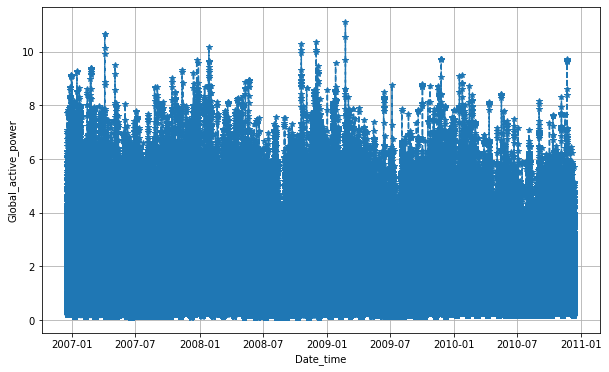

In [18]:
visualize_data(structure_df, 'Global_active_power')

In [19]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [20]:
def fill_null(df, method, method_type):
    data = df.copy()

    # check for null
    print('Check for null before method \n*********************')
    print(data.isnull().sum())

    # fill null
    if(method=='fillna'):
        if(method_type=='ffill'):
            data = data.fillna(method='ffill')
        elif(method_type=='bfill'):
            data = data.fillna(method='bfill')
        else:
            print('Enter a right method_type for {}...'.format(method))
            return
            
    elif(method=='interpolate'):
        if(method_type=='forward'):
            data = data.interpolate(method='linear', limit_direction='forward')

        elif(method_type=='backward'):
            data = data.interpolate(method='linear', limit_direction='backward')
        else:
            print('Enter a right method_type for {}...'.format(method))
            return
            
    else:
        print('Method is incorrect, enter a right method'.format(method))
        return
            
                
    # check for null
    print('\nCheck for null after method \n*********************')
    print(data.isnull().sum())

    return data
                

In [21]:
fill_null(structure_df, 'fillna', 'bfill')

Check for null before method 
*********************
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Check for null after method 
*********************
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [22]:
def sampling_df(df, tf, visual_col):
    data = df.copy()

    data = data.resample(tf).mean()
    visualize_data(data, visual_col)
    
    return data

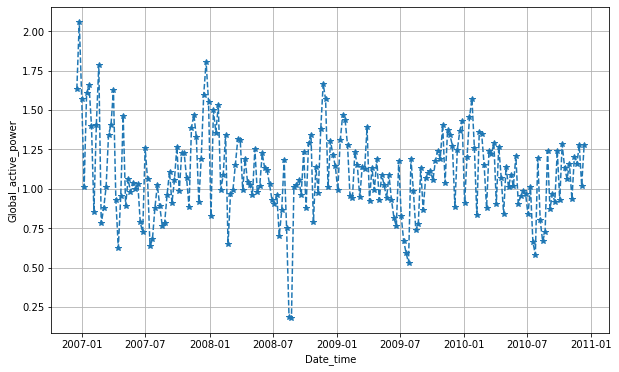

In [128]:
under_sampled_data = sampling_df(structure_df, '7D', 'Global_active_power')

In [24]:
def moving_average(df, rolling, visual_col):
    data = df.copy()
    MA = data[visual_col].rolling(rolling).mean()
    
    visualize_data(df, visual_col, MA)

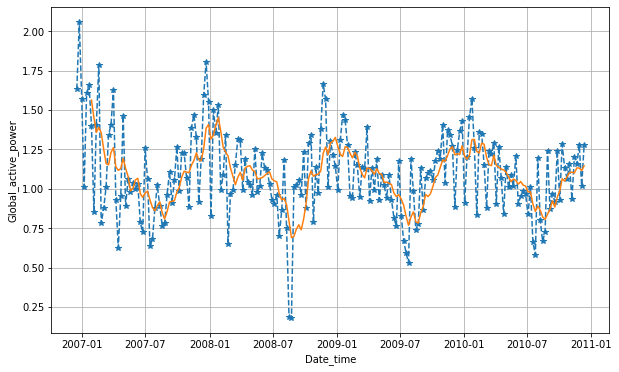

In [25]:
moving_average(under_sampled_data, 7, 'Global_active_power')

In [26]:
def decompose_data(df, visual_col, model):
    rcParams['figure.figsize'] = 15 , 8
    decompose_series = sm.tsa.seasonal_decompose(df[visual_col], model=model )
    decompose_series.plot()
    plt.show() 

In [27]:
filled_structure_data = fill_null(structure_df, 'interpolate', 'forward')

Check for null before method 
*********************
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Check for null after method 
*********************
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [28]:
filled_structure_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [29]:
under_sampled_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_time,,,,,,,
2006-12-16,1.633093,0.117969,241.086581,6.903830,0.979743,2.277729,8.202015
2006-12-23,2.061153,0.135012,242.107983,8.691865,1.541369,1.973909,6.931746
2006-12-30,1.570216,0.124330,239.568803,6.638658,1.277634,1.556658,6.751538
2007-01-06,1.012675,0.126139,238.607794,4.321833,1.582024,0.900378,5.736429
2007-01-13,1.605249,0.141548,240.478867,6.808572,1.820419,1.634686,8.214009


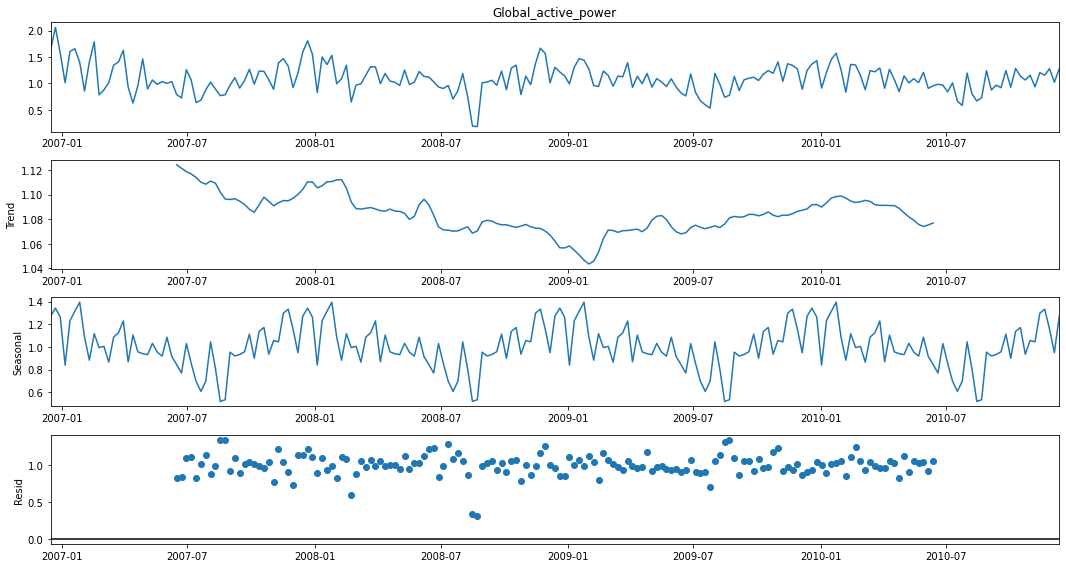

In [30]:
decompose_data(under_sampled_data, 'Global_active_power', 'multilicative')

In [31]:
def adfuller_model(df, col):
    data = df.copy()

    adf_result = adfuller(data[col])

    print('ADF Statistic: {}'.format(adf_result[0]))
    print('p-value: {}'.format(adf_result[1]))
    print('No. of lags used: {}'.format(adf_result[2]))
    print('No. of observations used : {}'.format(adf_result[3]))
    print('\nCritical Values:\n******************')

    for k, v in adf_result[ 4 ].items():
          print('{} : {}'.format(k,v)) 

In [32]:
adfuller_model(under_sampled_data, 'Global_active_power')

ADF Statistic: -4.608894213242634
p-value: 0.00012438063657767095
No. of lags used: 15
No. of observations used : 193

Critical Values:
******************
1% : -3.4646940755442612
5% : -2.8766348847254934
10% : -2.5748163958763994


In [58]:
def diff_data(df, visual_col, rolling):
    df_log = np.log(df)
    df_diff = df_log.diff(periods= 1 )
    plt.plot(df_diff.index, df_diff[visual_col], '-')
    plt.plot(df_diff[visual_col].rolling(rolling).mean(), color= 'red')
    plt.show()
    
    return df_diff

/home/igori/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


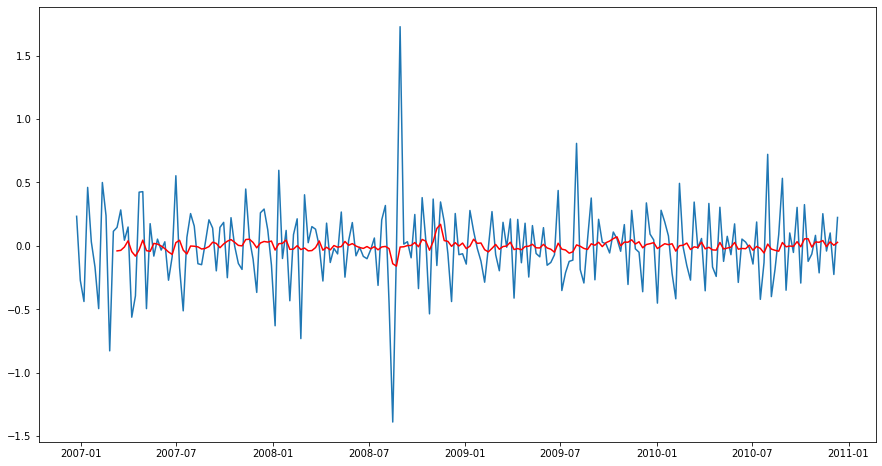

In [59]:
df_diff = diff_data(under_sampled_data, 'Global_active_power', 12)

In [60]:
df_diff

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_time,,,,,,,
2006-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-23,0.232789,0.134944,0.004228,0.230311,0.453136,-0.143163,-0.168268
2006-12-30,-0.272052,-0.082426,-0.010543,-0.269478,-0.187661,-0.237474,-0.026341
2007-01-06,-0.438618,0.014443,-0.004019,-0.429230,0.213695,-0.547482,-0.162933
2007-01-13,0.460683,0.115254,0.007811,0.454503,0.140361,0.596392,0.359004
...,...,...,...,...,...,...,...
2010-11-13,0.253352,-0.364136,-0.000339,0.234246,-0.041540,-0.493710,0.227684
2010-11-20,-0.040952,-0.155620,0.001537,-0.040245,0.301756,0.299766,-0.112438
2010-11-27,0.101480,0.161973,0.011991,0.078785,-0.450253,0.132843,0.509980


In [63]:
def stochastic_model(df, visual_col):
    plt.figure(figsize=(10 , 6))
    #ACF
    plot_acf(df[visual_col].iloc[1:])
    #PACF
    plot_pacf(df[visual_col].iloc[1:])
    plt.show()

<Figure size 720x432 with 0 Axes>

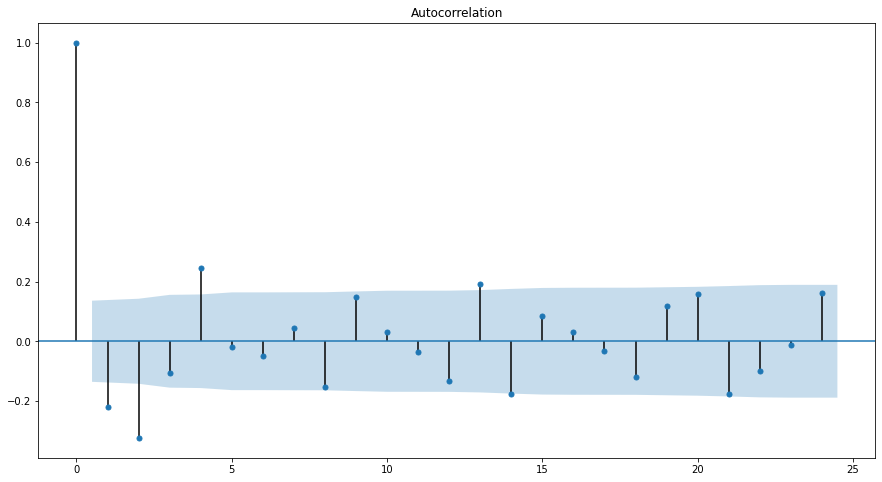

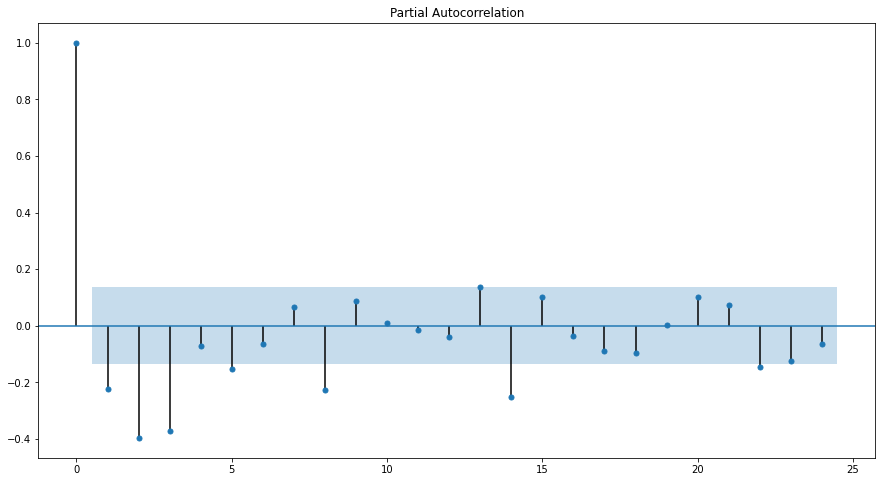

In [64]:
stochastic_model(df_diff, 'Global_active_power')

In [69]:
def arima_model(df, col, p, q, r):
    AR_model = ARIMA(df[col].iloc[1:], order=(p, q, r))
    AR_model_results = AR_model.fit()
    plt.plot(df[col])
    plt.plot(AR_model_results.fittedvalues, color='red')

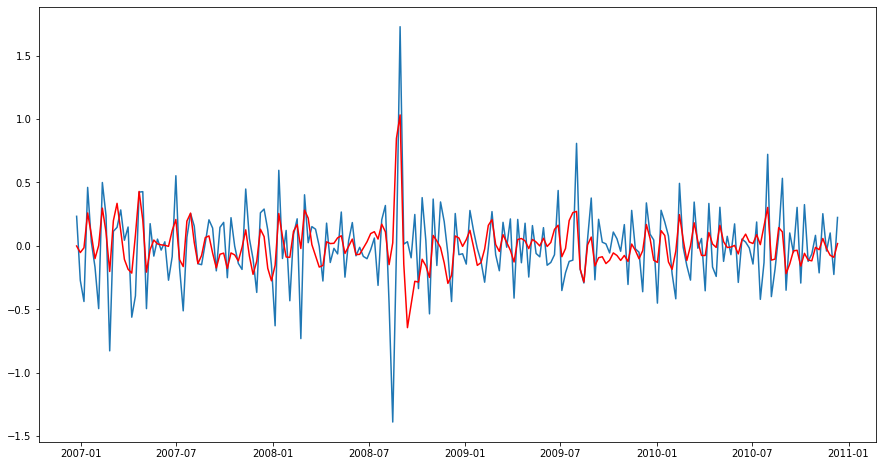

In [73]:
arima_model(df_diff, 'Global_active_power', 2, 0, 1)

In [160]:
from fbprophet.diagnostics import performance_metrics

from fbprophet.diagnostics import cross_validation

In [165]:
def prophesy(df, col):
    data = df[[col]]
    data = data.reset_index()
    data["Date_time"]= pd.to_datetime(data["Date_time"])
    data = data.rename(columns={"Date_time": "ds", col: "y"})
    print(data.head())   

    model = Prophet()
    model.fit(data)

    
    future = model.make_future_dataframe(periods=365, freq='D') 
    forecast = model.predict(future) 
    forecast.head()
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]
    #yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries
    
    predict = forecast[['yhat']]
    
    

    model.plot(forecast)
    plt.show()
    
    
#     df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
    
#     df_p = performance_metrics(forecast)
#     return df_p

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds         y
0 2006-12-16  1209.176
1 2006-12-17  3390.460
2 2006-12-18  2203.826
3 2006-12-19  1666.194
4 2006-12-20  2225.748


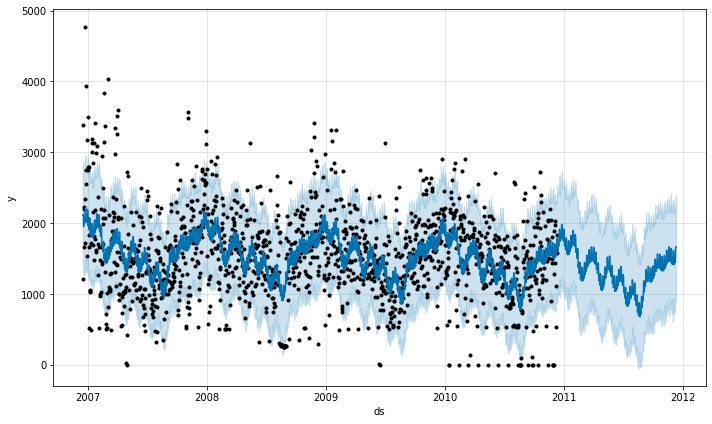

In [166]:
# under_sampled_data_month = sampling_df(structure_df, 'M', 'Global_active_power')

predict = prophesy(data, 'Global_active_power')

In [131]:
def sampling_df_sum(df, tf, visual_col):
    data = df.copy()

    data = data.resample(tf).sum()
    visualize_data(data, visual_col)
    
    return data

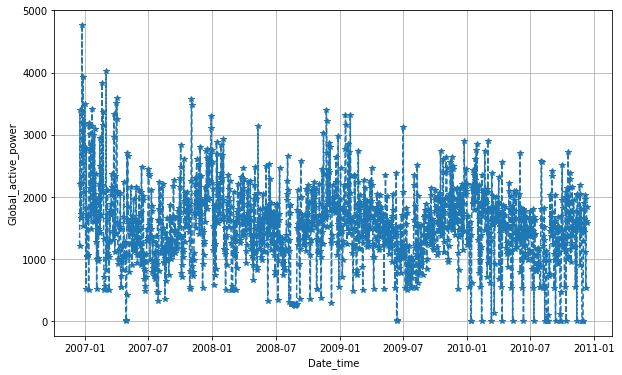

In [132]:
data = sampling_df_sum(structure_df, 'D', 'Global_active_power')

In [142]:
predict

,yhat
0,2114.446278
1,2117.972312
2,1950.701511
3,2052.340782
4,2058.055902
...,...
1817,1500.026675
1818,1437.304344
1819,1504.973822
1820,1662.761513


In [136]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [148]:
mean_absolute_percentage_error(data.Global_active_power[-365:].values,predict.yhat[-365:].values)

/home/igori/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in true_divide



inf

In [150]:
data.Global_active_power[-365:].values

array([1816.38 , 2138.814, 1794.862, 1940.116, 1394.874, 1717.182,
       1744.706, 2204.334, 1144.166, 2034.966, 1888.022, 1455.2  ,
       2905.894, 2127.648, 2183.618, 2195.452, 2094.098, 2047.968,
       2451.11 , 2211.892, 1224.252, 1693.778, 1298.728, 1687.44 ,
       1320.158, 1268.964, 1349.002,  555.664, 1593.318, 1504.82 ,
       1383.18 ,    0.   ,    0.   ,  618.488, 2196.76 , 2150.112,
       1906.556, 1881.098, 2433.508, 2351.728, 2137.856, 1790.626,
       2608.51 , 2269.42 , 1930.51 , 2067.564, 2760.902, 2110.234,
       2092.99 , 2842.728, 1799.196, 1308.836, 2157.432,  766.906,
       1648.622, 2187.91 ,  980.898, 1140.928,  549.482, 1392.492,
       1923.254, 1191.082,    0.   , 2351.556, 1686.698, 2097.132,
       1797.756, 2054.56 , 1761.156, 1953.572, 1983.728, 2740.314,
       1474.036, 1461.28 , 1914.278, 1880.204, 2120.156, 1765.056,
        711.666, 2083.454, 2903.014,  935.834, 1805.278, 1411.302,
       1394.186, 1120.074,  615.212, 1346.414, 1830.684, 1293.